In [104]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [105]:
from collections import defaultdict
from itertools import count

import numpy as np


import matplotlib.pyplot as plt
import plotly.offline as py
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import networkx as nx

In [106]:
file = "/home/ubuntu/data/tmp/karate/zkcc-77/karate_edges_78.txt"

In [141]:

def create_adjacency_matrix(file):
    node_neighbors = defaultdict(list)

    with open(file, "r") as fin:
        for line in fin:
            node_1, node_2 = line.strip().split('\t')
            node_1 = int(node_1)-1 #offset to make the integers start from zero
            node_2 = int(node_2)-1
            node_neighbors[node_1].append(node_2)

    number_of_nodes = len(node_neighbors)
    A = np.zeros((number_of_nodes, number_of_nodes))

    for node, neighbors in node_neighbors.items():
        for neighbor in neighbors:
            A[node, neighbor] = 1

    return A

def compute_modularity(A, communities, m):
    nrows, ncols = A.shape
    assert nrows == ncols
    nvertices = nrows

    modularity = 0.0
    for vertexi in range(nvertices):
        for vertexj in range(nvertices):
            ki = np.sum(A[vertexi,:])
            kj = np.sum(A[vertexj,:])
            if communities[vertexi] == communities[vertexj]:
                modularity += A[vertexi, vertexj] - (ki*kj)/(2*m)

    return modularity/(2*m)
    
def modularity_difference(A, communities, m, modularity, vertex, community):
    #save community of node
    original_community = communities[vertex]
    #change community
    communities[vertex] = community
    #compute new modularity
    new_modularity = compute_modularity(A, communities, m)
    #print(f"{nodei}, {communityi}, {self.modularity}, {new_modularity}")
    modularity_difference = new_modularity-modularity
    #restore community
    communities[vertex] = original_community
    return modularity_difference

def find_best_community(A, communities, m, modularity, vertex):
    unique_communities = np.unique(communities)
    max_modularity_difference = 0
    best_community = communities[vertex]
    for community in unique_communities:
        modularity_diff = modularity_difference(A, communities, m, modularity, vertex, community)
        if modularity_diff > max_modularity_difference:
            max_modularity_difference = modularity_diff
            best_community = community
    return best_community, max_modularity_difference

def reset_communities(communities):
    """
    reset the community vector so that the communities  start from zero
    
    Example:
    --------
    communities = [17,17,3,17,3,1,1,1,3,17]
    reset_communities(communities) == [0,0,1,0,1,2,2,2,1,0]
    """
    counter = count()
    community_mapper = defaultdict(lambda: next(counter))
    reset_communities = np.zeros((len(communities),), dtype=int)
    for vertex, community in enumerate(communities):
        reset_communities[vertex] = community_mapper[community]
    return reset_communities

def local_search(A, communities, m, modularity, seed=11):
    nvertices = len(communities)
    if seed>0:
        vertex_order = np.random.RandomState(seed=seed).permutation(nvertices)
    else:
        vertex_order = range(nvertices)

    is_modularity_increasing = True
    while is_modularity_increasing:
        is_modularity_increasing = False
        for vertex in vertex_order:
            best_community, modularity_difference = find_best_community(A, communities, m, modularity, vertex)
            if modularity_difference > 0:
                communities[vertex] = best_community
                modularity += modularity_difference
                #print(f"moving node {nodei} to community {best_community}, modularity diff {modularity_difference}, new modularity {self.modularity}")
                #print("verification modularity {}".format(self.compute_modularity()))
                is_modularity_increasing = True

    communities = reset_communities(communities)

    print(f"Finished phase1, new modularity: {modularity}")

    return communities, modularity

def reduce_network(A, communities):
    unique_communities = np.unique(communities)
    #print(unique_communities)
    n_communities = len(unique_communities)
    reduced_A = np.zeros((n_communities, n_communities))

    for i, communityi in enumerate(unique_communities):
        for j, communityj in enumerate(unique_communities):
            vertices_i = np.argwhere(communities == communityi).flatten()
            vertices_j = np.argwhere(communities == communityj).flatten()
            sub_A = A[vertices_i,:]
            sub_A = sub_A[:,vertices_j]
            reduced_A[i, j] = np.sum(np.sum(sub_A))

    print(f"Finished phase2, number of nodes/communities: {n_communities}")
    communities = np.array([i for i in range(reduced_A.shape[0])], dtype=int)
    
    return reduced_A, communities

def traceback_communities(reduced_communities, communities):
    #print("traceback")
    #print(communities)
    new_communities = np.zeros((len(communities,)),dtype=int)
    for vertex, community in enumerate(communities):
        #print(nodei,community)
        new_communities[vertex] = reduced_communities[community]
    return new_communities

def detect_communities(A, communities, community_hierarchy=[]):
    m = 0.5*np.sum(np.sum(A))
    modularity = compute_modularity(A, communities, m)

    local_communities, modularity = local_search(A, communities, m, modularity)
    community_hierarchy.append(local_communities)
    
    iteration = 1
    while True:
        A, communities = reduce_network(A, local_communities)
        print(f"Finished iteration {iteration}")

        local_communities, modularity = local_search(A, communities, m, modularity)

        expanded_communities = traceback_communities(local_communities, community_hierarchy[-1])

        if np.all(community_hierarchy[-1] == expanded_communities):
            print("communities stayed the same, stopping algorithm")
            break
            
        community_hierarchy.append(expanded_communities)

        iteration += 1

    return community_hierarchy



In [142]:
A = create_adjacency_matrix(file)
communities = np.array([i for i in range(A.shape[0])], dtype=int)
hierarchy = detect_communities(A, communities)

Finished phase1, new modularity: 0.38453320184089396
Finished phase2, number of nodes/communities: 6
Finished iteration 1
Finished phase1, new modularity: 0.4151051939513478
Finished phase2, number of nodes/communities: 4
Finished iteration 2
Finished phase1, new modularity: 0.4151051939513478
communities stayed the same, stopping algorithm


In [143]:
hierarchy

[array([0, 0, 0, 0, 1, 2, 2, 0, 3, 4, 1, 0, 0, 0, 4, 4, 2, 0, 4, 0, 4, 0,
        4, 4, 5, 5, 4, 4, 5, 4, 3, 5, 4, 4]),
 array([0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 2, 0,
        2, 2, 3, 3, 2, 2, 3, 2, 2, 3, 2, 2])]

In [130]:
def create_graph(A, communities):
    G=nx.Graph()
    
    for nodei in range(A.shape[0]):
        d = {"community": communities[nodei]}
        G.add_node(nodei+1, **d)
    
    for i, j in zip(*A.nonzero()):
        if communities[i] == communities[j]:
            weight = 100
        else:
            weight = 1
        G.add_edge(i+1, j+1, weight=weight)
        
    return G

In [131]:
def plot_graph(G, pos=None):
    plt.figure(figsize=(30,15))  
    
    node_communities = [d["community"] for _, d in G.nodes(data=True)]
    
    if pos==None:
        pos = nx.spring_layout(G, scale=30)  # positions for all nodes
    
    nx.draw_networkx_nodes(G, pos, node_color=node_communities)
    nx.draw_networkx_edges(G, pos)

    nx.draw_networkx_labels(G, pos, font_size=30, font_family='sans-serif')

    plt.axis('off')
    plt.show()
    
    return pos

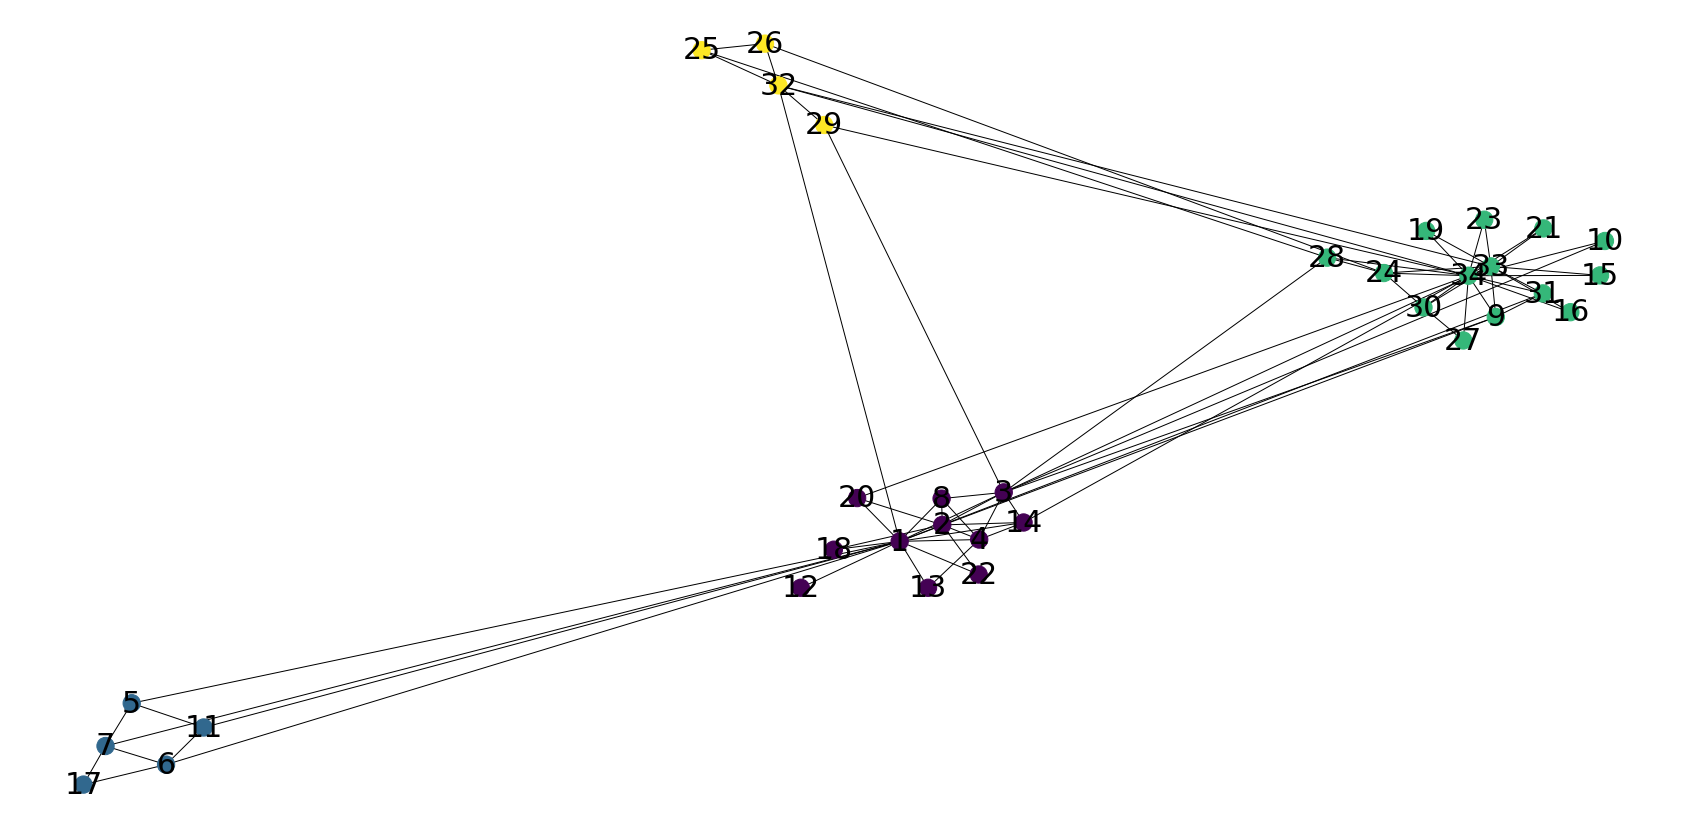

{1: array([-3.93138104, -8.96962775]),
 2: array([-2.57007105, -7.88454171]),
 3: array([-0.60764424, -5.73531579]),
 4: array([-1.39036918, -8.84925307]),
 5: array([-28.45850907, -19.6528922 ]),
 6: array([-27.36174758, -23.70376128]),
 7: array([-29.29517156, -22.47749694]),
 8: array([-2.59146956, -6.14804778]),
 9: array([15.10963061,  5.83973866]),
 10: array([18.59541163, 10.85636115]),
 11: array([-26.16083488, -21.25449139]),
 12: array([ -7.08895523, -12.0319144 ]),
 13: array([ -3.02466487, -12.03333958]),
 14: array([ 0.02618423, -7.72390256]),
 15: array([18.43879339,  8.58424943]),
 16: array([17.49022365,  6.15669921]),
 17: array([-30.        , -25.02194413]),
 18: array([-6.03412198, -9.51957936]),
 19: array([12.8854764 , 11.52124368]),
 20: array([-5.28936784, -6.11134754]),
 21: array([16.62971637, 11.68540707]),
 22: array([ -1.40733184, -11.15692302]),
 23: array([14.73915339, 12.2612697 ]),
 24: array([11.53522472,  8.74065735]),
 25: array([-10.25621053,  23.449

In [145]:
com = np. array([0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 2, 0,
        2, 2, 3, 3, 2, 2, 3, 2, 2, 3, 2, 2])
G = create_graph(A, com)
plot_graph(G)